In [1]:
# load data
import os
import pandas as pd
import numpy as np
# test models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import time
# feature importance plot
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


En utilisant les statistiques des variables pour chacune des series temporelles.

In [2]:
def linearize(u):
    """
    Fonction pour mettre en 1 seule lignes le tableau de statistiques pd.describe()
    """
    all=[]
    for line in range(len(u)):
        all.append(u.iloc[line])
    return pd.concat(all, axis=0).T

def load_data(directory = 'data/group3/config_1', drop_col='', drop_feat=''):

    """
    Fonction pour charger les donnée:
    directory : str() chemin d'acces
    drop_col : list() nom des statistiques à ne pas utiliser (pd.describe())
    drop_feat : list() nom des features à ne pas utiliser

    return : pd.DataFrame()
    """

    all_data=[]
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        data = pd.read_csv(f)
        if drop_col:
            data.drop(columns=drop_col, inplace=True)
        u = data.describe().T
        if drop_feat:
            u.drop(columns=drop_feat, inplace=True)
        number = pd.DataFrame(linearize(u)).T
        # add labels
        if directory == 'data/config1':
            number['label'] = int(filename.split('_')[1])
        else:
            number['label'] = int(filename[0])
        all_data.append(number)

    to_test = pd.concat(all_data)

    new_col=[]
    for stat_ in u.columns:
        for feat_ in data.columns:
            new_col.append(stat_.upper()+"_"+feat_)
    new_col.append('label')
    to_test.columns=new_col

    return to_test

to_test = load_data() # drop_col='t', drop_feat='count')
to_test.shape

(223, 81)

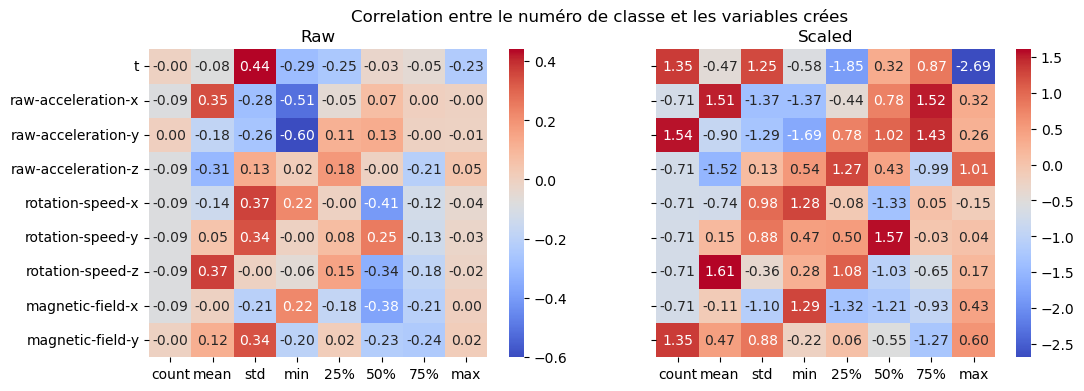

In [3]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler

    # preapre data
label_correlations = to_test.corr()[-1:].iloc[:,:-1]
stats = label_correlations.describe().index.tolist()
r={}
for i, stat_ in enumerate(stats):
    r[stat_] = label_correlations.iloc[:,i*9:(i+1)*9].values.reshape(9)
r = pd.DataFrame(r)
    # prepare figure
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
r.index=['-'.join(a.split('_')[1:]) for a in label_correlations.columns[:9].values]
    # original data
sns.heatmap(r,annot=True,cmap='coolwarm',fmt=".2f",ax=ax1)
ax1.set_title("Raw")
    # scaled sata
sc=StandardScaler()
r=sc.fit_transform(r)
sns.heatmap(r,annot=True,cmap='coolwarm',fmt=".2f",ax=ax2)
ax2.set_xticklabels(stats)
ax2.set_yticklabels("")
ax2.set_title("Scaled")
    # plot
fig.suptitle("Correlation entre le numéro de classe et les variables crées")
plt.show()

Analyse les correlation entre des variables lineaire n'a pas de sens ici car nous avons un probleme de classification. A la place on peut utiliser une analyse anova


# analyse anova

In [4]:
# import statsmodels.api as sm
# from statsmodels.formula.api import ols
# df=to_test.copy()
# df['label'] = df['label'].astype('category')
# n_features = len(df.columns[:-1])//8

# df.columns = ['_'+a.replace('%','') for a in df.columns[:-1]]+['label'] # formatage pour sm.stats
# # Loop through each column (except 'label') and perform ANOVA
# annova_results=[]
# for column in df.columns[:-1]:  # Exclude 'label'
#     formula = f"{column} ~ label"
#     model = ols(formula, data=df).fit()
#     anova_table = sm.stats.anova_lm(model, typ=2)
#     metrique = 'PR(>F)'
#     annova_results.append(anova_table[metrique][0])

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/dv/gzhyqctn53s9bh23g7tbvl940000gn/T/ipykernel_19846/3399219392.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annova_results.append(anova_table[metrique][0])
/var/folders/dv/gzhyqctn53s9bh23g7tbvl940000gn/T/ipykernel_19846/3399219392.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annova_results.append(anova_table[metrique][0])
/var/folders/dv/gzhyqctn53s9bh23g7tbvl940000gn/T/ipykernel_19846/3399219392.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acc

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/dv/gzhyqctn53s9bh23g7tbvl940000gn/T/ipykernel_19846/3399219392.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annova_results.append(anova_table[metrique][0])
/var/folders/dv/gzhyqctn53s9bh23g7tbvl940000gn/T/ipykernel_19846/3399219392.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annova_results.append(anova_table[metrique][0])
/var/folders/dv/gzhyqctn53s9bh23g7tbvl940000gn/T/ipykernel_19846/3399219392.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acc

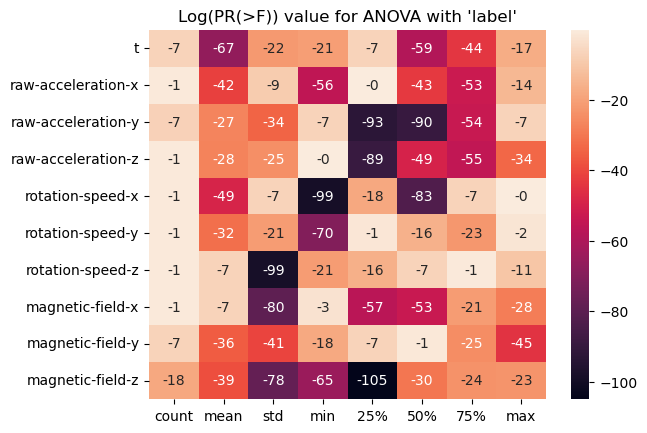

In [5]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

def plot_anova(to_test=to_test, metrique='PR(>F)'):
    """"
    Fonction pour analyser la correlation entre variables continues et classe à prédire
    to_test : pd.DataFrame() 
    metrique : str() une des metrique du module sm.stats.anova_lm ['PR(>F)','F',...]
    """
    df=to_test.copy()
    df['label'] = df['label'].astype('category')
    n_features = len(df.columns[:-1])//8

    df.columns = ['_'+a.replace('%','') for a in df.columns[:-1]]+['label'] # formatage pour sm.stats
    # Loop through each column (except 'label') and perform ANOVA
    annova_results=[]
    for column in df.columns[:-1]:  # Exclude 'label'
        formula = f"{column} ~ label"
        model = ols(formula, data=df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        annova_results.append(anova_table[metrique][0])

    r={}
    for i, stat_ in enumerate(stats):
        r[stat_] = annova_results[i*n_features:(i+1)*n_features]
    s=r
    r = pd.DataFrame(r)
    r.index=['-'.join(a.split('_')[1:]) for a in label_correlations.columns[:n_features].values]
    sns.heatmap(np.log(r), annot=True, fmt='.0f')           # mettre au log si P value
    plt.title(f"Log({metrique}) value for ANOVA with 'label'")
    return plt.show()
plot_anova(to_test,'PR(>F)')

metrique = 'PR(>F)' ==> If the overall P value is small, then it is unlikely that the differences you observed are due to random sampling. You can reject the idea that all the populations have identical means. This doesn't mean that every mean differs from every other mean, only that at least one differs from the rest. Look at the results of post tests to identify where the differences are. 

metrique = 'F' ==> If the null hypothesis is true, you expect F to have a value close to 1.0 most of the time. A large F ratio means that the variation among group means is more than you'd expect to see by chance. You'll see a large F ratio both when the null hypothesis is wrong (the data are not sampled from populations with the same mean) and when random sampling happened to end up with large values in some groups and small values in others. 

# tests modeles

In [7]:
# modele lineaire ou ensembliste
def test_models(to_test=to_test):
    """
    Fonction permettant de tester 4 modèles pour la classification
    to_test : pd.DataFrame()
    """

    X=sc.fit_transform(to_test.drop("label", axis=1))
    y=to_test["label"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    models=[
        LinearRegression(),
        LogisticRegression(solver='liblinear'),
        DecisionTreeClassifier(),
        RandomForestClassifier()
    ]

    for model in models:
        cv =cross_validate(model,X_train,y_train,cv=10)
        print(f"{model} score :{round(cv['test_score'].mean(),2)}, time {round(cv['score_time'].mean(),4)}")
    return X, y, X_train, X_test, y_train, y_test

X, y, X_train, X_test, y_train, y_test = test_models(to_test)


LinearRegression() score :0.33, time 0.0002
LogisticRegression(solver='liblinear') score :0.85, time 0.0004
DecisionTreeClassifier() score :0.73, time 0.0003
RandomForestClassifier() score :0.98, time 0.0037


It is possible that we introduce a biais with the columns time, and we need to have a look at the most important features 

In [8]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

def optimize_logreg(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    logreg_model = LogisticRegression(multi_class='auto', solver='liblinear')

    param_grid = {
        'C': np.logspace(-4, 4, 40),  
        'penalty': ['l1', 'l2'], 
        'max_iter': [100, 500, 1000, 10000],  
    }

    random_search = RandomizedSearchCV(logreg_model, 
                                    param_distributions=param_grid, 
                                    n_iter=10, 
                                    scoring='accuracy', 
                                    cv=5, 
                                    random_state=42,
                                    refit=True)

    random_search.fit(X_train, y_train)
    t0 = time.time()
    y_pred = random_search.best_estimator_.predict(X_test)
    t_fit = time.time()-t0
    from sklearn.metrics import classification_report
    print(classification_report(y_test,y_pred))
    print("fit time :",round(t_fit,4))
    return random_search

random_search = optimize_logreg(X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.80      0.57      0.67         7
           2       0.88      1.00      0.93         7
           3       0.80      0.67      0.73         6
           4       1.00      1.00      1.00         6
           5       0.67      0.57      0.62         7
           6       0.70      1.00      0.82         7
           7       0.70      1.00      0.82         7
           8       1.00      1.00      1.00         8
           9       1.00      0.67      0.80         6

    accuracy                           0.84        67
   macro avg       0.85      0.83      0.83        67
weighted avg       0.85      0.84      0.83        67

fit time : 0.0008


Pour le LogReg optimisé, la precision globale (macro et weighet) est identique en changeant le random state, par contre les classe ayant les plus mauvaises precision changent

In [24]:
def feat_importance_logreg(random_search=random_search, to_test=to_test, show=False):
    # fit the model with best params from random search
    p_ = random_search.best_params_
    model_lr = LogisticRegression(**p_,solver='liblinear')
    model_lr.fit(X, y)

    if show:
        # extract feature importance
        coefficients = model_lr.coef_[0]
        feature_importance = pd.DataFrame({'Feature': to_test.columns[:-1], 'Importance': np.abs(coefficients)})

        r={}
        for i, stat_ in enumerate(stats):
            r[stat_] = feature_importance.iloc[i*10:(i+1)*10,1:].values.reshape(10)
        s=r
        r = pd.DataFrame(r)
        r.index=['-'.join(a.split('_')[1:]) for a in label_correlations.columns[:10].values]
        sns.heatmap(r*10, annot=True, fmt='.1f')
        plt.title(f"abs(Variable importance)*10^1 pour {model_lr}")
        plt.show()
    return model_lr
model_lr = feat_importance_logreg(random_search, to_test, show=True)

ValueError: All arrays must be of the same length

le mean et la mediane du temps ne valident pas la nulle hypoyhese. ????

In [10]:
def optimize_rfc(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    param_grid = {
        'n_estimators': [50, 100, 200, 300],
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2'],
    }

    random_search = RandomizedSearchCV(RandomForestClassifier(), 
                                    param_distributions=param_grid, 
                                    n_iter=10, 
                                    scoring='accuracy', 
                                    cv=5, 
                                    random_state=42, 
                                    refit=True)
    random_search.fit(X_train, y_train)

    start_time = time.time()
    y_pred = random_search.best_estimator_.predict(X_test)
    end_time = time.time()

    print("best estimator",random_search.best_estimator_)
    print(classification_report(y_test,y_pred))
    print("time to predict :",round(end_time - start_time,4))
    return random_search

random_search = optimize_rfc(X_train, y_train, X_test, y_test)

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

best estimator RandomForestClassifier(criterion='entropy', max_depth=40, max_features='auto',
                       min_samples_leaf=2, n_estimators=300)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         7
           3       1.00      0.83      0.91         6
           4       1.00      0.67      0.80         6
           5       0.70      1.00      0.82         7
           6       0.86      0.86      0.86         7
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00         8
           9       1.00      1.00      1.00         6

    accuracy                           0.94        67
   macro avg       0.96      0.94      0.94        67
weighted avg       0.95      0.94      0.94        67

time to predict : 0.0115


/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


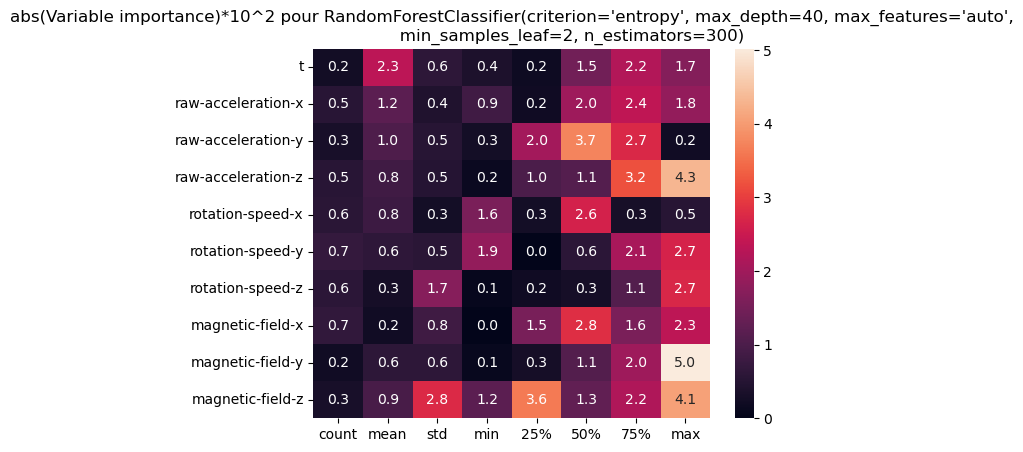

In [11]:

import numpy as np
def feat_importance_rfc(random_search=random_search, to_test=to_test, show=False):
    # fit the model with best params from random search
    p_ = random_search.best_params_
    model_rfc = RandomForestClassifier(**p_)
    model_rfc.fit(X, y)

    if show:
        # extract feature importance
        coefficients = model_rfc.feature_importances_
        feature_importance = pd.DataFrame({'Feature': label_correlations.columns, 'Importance': np.abs(coefficients)})
        r={}
        for i, stat_ in enumerate(stats):
            r[stat_] = feature_importance.iloc[i*10:(i+1)*10,1:].values.reshape(10)
        s=r
        r = pd.DataFrame(r)
        r.index=['-'.join(a.split('_')[1:]) for a in label_correlations.columns[:10].values]
        sns.heatmap(r*100, annot=True, fmt='.1f')
        plt.title(f"abs(Variable importance)*10^2 pour {model_rfc}")
        plt.show()

    return model_rfc
model_rfc = feat_importance_rfc(random_search, to_test, show=True)

* ==> DecisionTreeClassifier

# test du modele rfc sur un autre dataset

In [12]:
to_test2 = load_data('data/config1')

              precision    recall  f1-score   support

           0       0.53      0.58      0.55        31
           1       0.25      0.47      0.33        30
           2       0.29      0.37      0.32        30
           3       0.12      0.13      0.12        30
           4       0.18      0.06      0.09        33
           5       0.36      0.80      0.49        30
           6       0.06      0.03      0.04        30
           7       0.65      0.43      0.52        30
           8       0.07      0.03      0.04        31
           9       0.20      0.10      0.13        30

    accuracy                           0.30       305
   macro avg       0.27      0.30      0.27       305
weighted avg       0.27      0.30      0.26       305



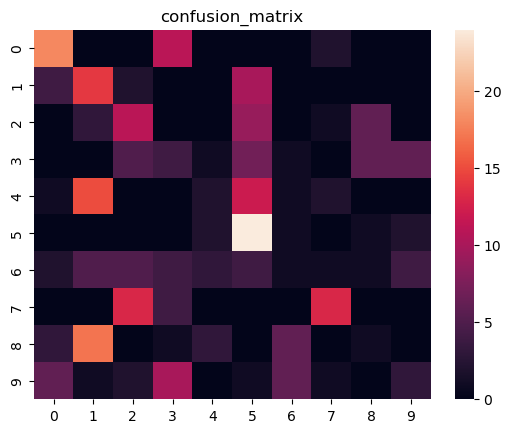

In [13]:
y_pred = model_lr.predict(X=sc.fit_transform(to_test2.drop("label", axis=1)))
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(to_test2["label"], y_pred))
plt.title("confusion_matrix")
print(classification_report(to_test2["label"], y_pred))

              precision    recall  f1-score   support

           0       0.49      0.61      0.54        31
           1       0.25      0.43      0.32        30
           2       0.26      0.33      0.29        30
           3       0.37      0.43      0.40        30
           4       0.15      0.12      0.14        33
           5       0.52      0.50      0.51        30
           6       0.00      0.00      0.00        30
           7       0.53      0.63      0.58        30
           8       0.15      0.06      0.09        31
           9       0.37      0.33      0.35        30

    accuracy                           0.34       305
   macro avg       0.31      0.35      0.32       305
weighted avg       0.31      0.34      0.32       305



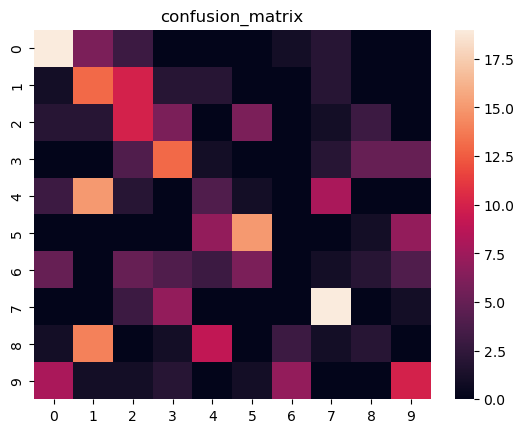

In [14]:
y_pred = model_rfc.predict(X=sc.fit_transform(to_test2.drop("label", axis=1)))
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(to_test2["label"], y_pred))
plt.title("confusion_matrix")
print(classification_report(to_test2["label"], y_pred))

# conclusion
* Le modèle entrainé sur une seul dataset (dont l'aquisition s'est faite de facon similaire - c.a. tracer les chiffres sur le plan d'une table) n'est pas generalisable
* il faut augmenter le nombre de données pour l'entrainement en combinant les datasets

Text(0.5, 1.0, 'repartition des données entre chaque classe')

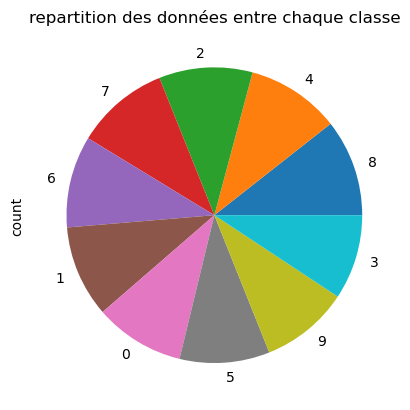

In [15]:
to_test3 = pd.concat([to_test,to_test2], axis=0)
to_test3.label.value_counts().plot.pie()
plt.title("repartition des données entre chaque classe")

In [16]:
X, y, X_train, X_test, y_train, y_test = test_models(to_test3)

LinearRegression() score :-0.46, time 0.0003
LogisticRegression(solver='liblinear') score :0.78, time 0.0003
DecisionTreeClassifier() score :0.75, time 0.0003
RandomForestClassifier() score :0.94, time 0.0043


# Feature importance configuration 3 == quaternions

In [17]:
to_test4 = load_data('data/group3/config_3')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/dv/gzhyqctn53s9bh23g7tbvl940000gn/T/ipykernel_19846/1462667111.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annova_results.append(anova_table[metrique][0])
/var/folders/dv/gzhyqctn53s9bh23g7tbvl940000gn/T/ipykernel_19846/1462667111.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annova_results.append(anova_table[metrique][0])
/var/folders/dv/gzhyqctn53s9bh23g7tbvl940000gn/T/ipykernel_19846/1462667111.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acc

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/dv/gzhyqctn53s9bh23g7tbvl940000gn/T/ipykernel_19846/1462667111.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annova_results.append(anova_table[metrique][0])
/var/folders/dv/gzhyqctn53s9bh23g7tbvl940000gn/T/ipykernel_19846/1462667111.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annova_results.append(anova_table[metrique][0])
/var/folders/dv/gzhyqctn53s9bh23g7tbvl940000gn/T/ipykernel_19846/1462667111.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acc

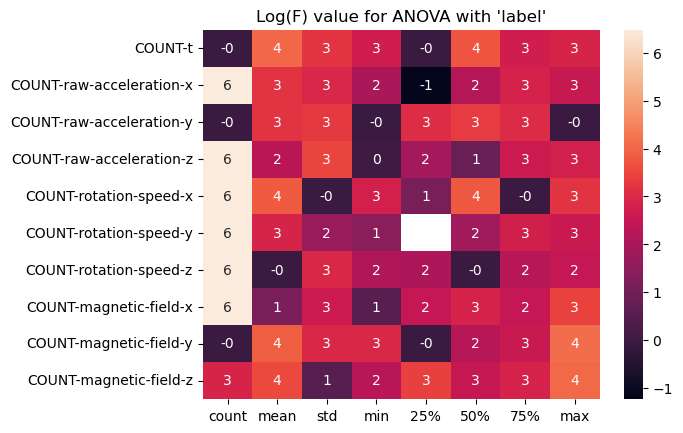

''

In [27]:
def plot_anova_quaternion(to_test4=to_test4, metrique='PR(>F)'):
    df=to_test2.copy()
    df['label'] = df['label'].astype('category')
    n_features = len(df.columns[:-1])//8
    df.columns = ['_'+a.replace('%','') for a in df.columns[:-1]]+['label'] # formatage pour sm.stats
    # Loop through each column (except 'label') and perform ANOVA
    annova_results=[]
    for column in df.columns[:-1]:  # Exclude 'label'
        formula = f"{column} ~ label"
        model = ols(formula, data=df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        annova_results.append(anova_table[metrique][0])
    r={}
    for i, stat_ in enumerate(stats):
        r[stat_] = annova_results[i*n_features:(i+1)*n_features]
    s=r
    r = pd.DataFrame(r)
    r.index=['-'.join(a.split('_')[1:]) for a in df.columns[:n_features].values]
    sns.heatmap(np.log(r), annot=True, fmt='.0f')           # mettre au log si P value
    plt.title(f"Log({metrique}) value for ANOVA with 'label'")
    plt.show()
    return ''
plot_anova_quaternion(to_test4=to_test4, metrique='F')

In [19]:
X, y, X_train, X_test, y_train, y_test = test_models(to_test4)

LinearRegression() score :-0.15, time 0.0012
LogisticRegression(solver='liblinear') score :0.96, time 0.0007
DecisionTreeClassifier() score :0.88, time 0.0003
RandomForestClassifier() score :0.98, time 0.0037


In [20]:
# results config 1

# LinearRegression() score :-0.25, time -0.0002
# LogisticRegression(solver='liblinear') score :0.86, time -0.0003
# DecisionTreeClassifier() score :0.73, time -0.0003
# RandomForestClassifier() score :0.98, time -0.0036

In [21]:
to_test4 = load_data('data/group3/config_3', drop_col='t')
X, y, X_train, X_test, y_train, y_test = test_models(to_test4)

LinearRegression() score :0.63, time 0.0002
LogisticRegression(solver='liblinear') score :0.95, time 0.0003
DecisionTreeClassifier() score :0.86, time 0.0003
RandomForestClassifier() score :0.98, time 0.0035


In [22]:
to_test4 = load_data('data/group3/config_3', drop_feat='count')
X, y, X_train, X_test, y_train, y_test = test_models(to_test4)

LinearRegression() score :0.02, time 0.0002
LogisticRegression(solver='liblinear') score :0.95, time 0.0003
DecisionTreeClassifier() score :0.87, time 0.0003
RandomForestClassifier() score :0.98, time 0.0035


In [29]:
to_test4 = load_data('data/group3/config_3', drop_col='t', drop_feat=['count','25%'])
X, y, X_train, X_test, y_train, y_test = test_models(to_test4)

LinearRegression() score :0.63, time 0.0003
LogisticRegression(solver='liblinear') score :0.92, time 0.0003
DecisionTreeClassifier() score :0.89, time 0.0003
RandomForestClassifier() score :0.96, time 0.0036
